# Machine Learning with Region Correlation at All Sites

This notebook investigates the performance of machine learning models to recognize ADHD in subjects. 
This dataset consits of preprocessed data from 6 of the 7 sites from the ADHD-200 Competition set and the diagnosis corresponding to each subject.

The features for this analysis contains the correlation coefficient between each region determined by the AAL atlas. 

This notebook runs two tests to evaluate the accuracy of multiple classification models.
1. Multi-class diagnosis (uses all diagnosis types)
2. Binary classification (if subject has ADHD or not)

## Imports

These are the imports that are required for this notebook to run properly

- `os` to access the file

- `pandas` to work with dataframes

- `numpy` for linear algebra

- `seaborn` for customizable plotting

- `matplotlib.pyplot` for plotting


- `train_test_split()` for splitting data into a training and testing set

- `LogisticRegression` for a logistic regression machine learning model

- `KNeighborsClassifier` for a KNN machine learning model

- `SVC` for a SVM machine learning model

- `LinearDiscriminantAnalysis` for a LDA machine learning model

- `Voting Classifier` for ensemble methods


- `accuracy_score()` to evaluate the accuracy of the model

- `confusion_matrix` and `ConfusionMatrixDisplay` for viewing confusion matrices

- `StratifiedKFold, cross_valscore()` for cross validation

In [1]:
# Major packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Model related
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

# Accuracy related
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score

### Models

These are the models that will be used in all accuracy evaluations.

In [2]:
# Create a list to hold the models
models = []

# Create the models
logr = LogisticRegression()
knn = KNeighborsClassifier()
svm = SVC()
lda = LinearDiscriminantAnalysis()
ens = VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm), ('lda',lda)])
ensl = VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm)])

# Add the models to the list
models.append(('LR', logr))
models.append(('KNN', knn))
models.append(('SVM', svm))
models.append(('LDA', lda))
models.append(('Ensemble', ens))
models.append(('Ensemble Less', ensl))

## Functions

There are two basic functions that will be used to create the machine learning model

1. get_base_filepath()

2. extract_features()

3. make_predictions()

4. evaluate_models()

5. get_accuracies()

6. perform_cross_validation()

### get_base_filepath()

Access the filepath for th ebase folder of the project. 
From here, any other asset of the project can be located.

**Input:** None

**Output:** The filepath to the root of the folder

In [3]:
def get_base_filepath():
    '''
    Access the filepath for the base folder of the project
    
    Input: None
    
    Output: The filepath to the root of the folder
    '''
    # Get current directory
    os.path.abspath(os.curdir)

    # Go up a directory level
    os.chdir('..')
    os.chdir('..')

    # Set baseline filepath to the project folder directory
    base_folder_filepath = os.path.abspath(os.curdir)
    return base_folder_filepath

### extract_features()

Create a dataframe using the mean of regions over time.

**Input:** filepath to open the dataframe
    
**Output:** dataframe of correlations between region

In [4]:
def extract_features(filepath):
    '''
    Create a dataframe correlation of the regions over time
    
    Input: filepath to open the dataframe
    
    Output: dataframe of correlations between region
    '''
    # Read the filepath as a dataframe (use 1 tab as separator and the first line as the header)
    df = pd.read_csv(filepath, sep=r'\s{1,}', engine='python', header=0)
    
    # Drop two features that get in the way of evaluation
    df = df.drop('File', axis=1)
    df = df.drop('Sub-brick', axis=1)
    
    # Get the correlation matrix of the dataframe
    cor = df.corr()
    
    # Create an empty list to store the correlations
    corr_vector = []
    
    # Loop through every row in the dataframe
    for row in range(len(cor.index)):
        # Loop through every feature in the dataframe
        for feature in range(len(cor.columns)):
            # Exclude unwanted values
            #    1 when row number = feature number
            #    repeat when row number > feature number
            if row >= feature:
                continue
            
            # Add the correlation value to the vector
            corr_vector.append(cor.iloc[row, feature])
    
    # Return the correlation for each of the regions (method of vectorizing)
    return corr_vector

### normalize()

Normalizes a Series

**Input:** A feature of type Series

**Output:** The normalized feature of type Series

**Dependencies:** Used in `normalize_features()`

In [5]:
def normalize(feature):
    '''
    This function normalizes a Series
    
    Input: A feature of type Series
    
    Output: The normalized feature of type Series
    '''
    return (feature - feature.mean())/feature.std()

### normalize_features()

Normalizes all features in a given dataframe. This will normalize ALL features, so ensure that the inputted dataframe consists only of numeric values.

**Input:** A dataframe to normalize

**Output:** A normalized dataframe

**Dependencies:** Uses `normalize()`

In [6]:
def normalize_features(df):
    '''
    This function normalizes all features in a dataframe
    
    Input: A pandas dataframe
    
    Output: The normalized dataframe
    '''
    for column in df.columns:
        df[column] = normalize(df[column])
    return df

### get_statistics()

Get the descriptive statistics for a list of values
    
**Input:** A list of accuracies
    
**Output:** The mean, std, max, and min for each model's accuracy

In [7]:
def get_statistics(accuracy_list):
    '''
    Get the descriptive statistics for a list of values
    
    Input: A list of accuracies
    
    Output: The mean, std, max, and min for each model's accuracy
    '''
    # Create empty lists for descriptive statistics
    means = []
    stds = []
    maxes = []
    mins = []
    
    # Access the descriptive statistics for each list of accuracies
    for accuracy in accuracy_list:
        accuracy_np = np.array(accuracy)
        means.append(accuracy_np.mean())
        stds.append(accuracy_np.std())
        maxes.append(accuracy_np.max())
        mins.append(accuracy_np.min())
        
    # Create a list for the statistics
    stats = [means, stds, maxes, mins]
    return stats

### make_predictions()

Fit a model using the training data, 
make predictions on a testing set, 
and get the accuracy of the model.

**Input:** 
- A model to use to make predictions
- Set of training features
- Set of testing features
- Set of training targets
- Set of testing targets

**Output:** 
- Predictions for models
- Accuracy of the model


**Dependencies:**
- Used in `evaluate_models()`

In [8]:
def make_predictions(model, X_trn, X_tst, y_trn, y_tst):
    '''
    Get the accuracy of a model
    
    Input:
        - A model to use to make predictions
        - Set of training features
        - Set of testing features
        - Set of training targets
        - Set of testing targets
        
    Output: 
        - Predictions for models
        - Accuracy of the model
    '''
    
    # Train the model on the training set
    model_fit = model.fit(X_trn, y_trn)
    
    # Make predictions on the testing features
    y_pred = model_fit.predict(X_tst)
    
    # Compare the predictions to the true values
    accuracy = accuracy_score(y_pred, y_tst)
    
    # Return the predictions and accuracy
    return y_pred, accuracy

### evaluate_models()

Evaluate the performance of models on a set of features and targets.

**Input:**
- Set of features
- Set of targets
        
**Output:** 
- Confusion matrices for models
- Accuracy of models

**Dependencies:**
- Uses `make_predictions()`
- Used in `get_accuracies()`

In [9]:
def evaluate_models(X, y):
    '''
    Evaluate the performance of models on a set of features and targets.
    
    Input:
        - Set of features
        - Set of targets
        
    Output: 
        - Confusion matrices for models
        - Accuracy of models
    '''
    # Create empty lists to store values
    predictions = dict()
    accuracies = []
    confusion_matrices = []
    
    # Separate the data into training and testing sets
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y)
    
    # Evaluate the accuracies using each model
    for name, model in models:
        pred, acc = make_predictions(model, X_trn, X_tst, y_trn, y_tst)
        predictions[name] = pred
        accuracies.append(acc)

    # Get the confusion matrix for each set of predictions
    for name, model in models:
        confusion_matrices.append(confusion_matrix(predictions[name], y_tst))
    
    # Return the accuracy and confusion matrices in a list format
    return accuracies, confusion_matrices

### get_accuracies()

Get 100 accuracies for the models

**Input:**
- Set of features
- Set of targets
        
**Output:** 
- List of 100 accuracies for models
- LIst of 100 confusion matrices for models

**Dependencies:**
- Uses `evaluate_models()`

In [10]:
def get_accuracies(X, y):
    '''
    Get 100 accuracies for the models.
    
    Input:
        - Set of features
        - Set of targets
        
    Output: 
        - List of 100 accuracies for models
        - LIst of 100 confusion matrices for models
    '''
    
    accuracies = [[],[],[],[],[],[]]
    matrices = [[],[],[],[],[],[]]
    
    # Run 100 iterations of evaluating the model
    for i in range(100):
        # Get the accuracy for this iteration
        accs, cf_matrices = evaluate_models(X, y)
        
        for i in range(len(models)):
            accuracies[i].append(accs[i])
            matrices[i].append(cf_matrices[i])
                   
    # Return a list of all accuracies and confusion matrices
    return accuracies, matrices

### perform_cross_validation()

Use a stratified K-fold for cross validation for the three classification models 

**Input:** 
- A dataframe containing the features use to build the model
- A Series of the true values associated with the feature list
    
**Output:** Printed result for the mean and standard deviation of each model

In [11]:
def perform_cross_validation(X_train, y_train):
    '''
    Input: 
        - A dataframe containing the features use to build the model
        - A Series of the true values associated with the feature list
    
    Output: Printed result for the mean and standard deviation of each model
    '''
    # Create an empty dictionary to store the results
    results = dict()

    # Loop through the models
    for name, model in models:
        # Create a Stratified K-fold for cross validation
        kfold = StratifiedKFold(n_splits=10)
        
        # Apply cross validation using the current model
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
        
        # Add the mean and standard deviation to the dictionary
        results[name] = (cv_results.mean(), cv_results.std())

    # Print the results
    print('Model\t\tCV Mean\t\tCV std')
    print(results)

### get_avg_cfm()

Get the average confusion matrix for a list of 100 matrices
    
**Input:** a list of 100 confusion matrices
    
**Output:** the average confusion matrix

**Dependencies:** Used in `get_model_cfms()`

In [12]:
def get_avg_cfm(cfms):
    '''
    Get the average confusion matrix for a list of 100 matrices
    
    Input: a list of 100 confusion matrices
    
    Output: the average confusion matrix
    '''
    # Create an empty confusion matrix based on the size
    if len(cfms[0]) == 2:
        cfm = [[0,0],
                [0,0]]
    else:
        cfm = [[0,0,0,0],
               [0,0,0,0],
               [0,0,0,0],
               [0,0,0,0]]
          
            
    # Sum up the values for each index in the confusion matrix
    for matrix in cfms:
        for row in range(len(matrix)):
            for col in range(len(matrix[row])):
                # If the row or column are out of bounds, skip it and move on
                if (len(matrix)==3 and len(cfm)==4) and (col==3 or row==3):
                    continue
                    
                # If the row or column is at diagnosis 2 and the matrix is the incorrect size, move on
                elif (len(matrix)==3 and len(cfm)==4) and (col==2 or row==2):
                    continue
                    
                # Otherwise, add the element to the sum matrix
                cfm[row][col] += matrix[col][row]
                
                
    # Divide by the number of values in the set
    for row in range(len(cfm)):
        for col in range(len(cfm[row])):
            cfm[row][col] /=100       
    
    # Return the mean confusion matrix
    return cfm

### get_model_cfms()

Get the confusion matrix for each model; intended for use after 100-iteration train/test split
    
**Input:** A list of the confusion matrices for each model
    
**Output:** The average confusion matrix for each model

**Dependencies:**
- Uses `get_avg_cfm()`
- Used in `print_model_cfms()`

In [13]:
def get_model_cfms(cfms):
    '''
    Get the confusion matrix for each model; intended for use after 100-iteration train/test split
    
    Input: A list of the confusion matrices for each model
    
    Output: The average confusion matrix for each model
    '''
    # Create an empty list to store the average confusion matrices in
    model_cfms = []
    
    # Get the average cfm for each model type
    for cfm_set in cfms:
        model_cfms.append(get_avg_cfm(cfm_set))
    
    # Return the average confusion matrices for each model type
    return model_cfms

### print_confusion_matrix()

Print a confusion matrix

**Input:**

- Confusion matrix to print
- A string to make a more clear title for the graph
        
**Ouput:** Display the confusion matrix

**Dependencies:**
- Used in `print_model_cfms()`

In [14]:
def print_confusion_matrix(cmf, name):
    '''
    Print a confusion matrix
    
    Input:
        - Confusion matrix to print
        - A string to make a more clear title for the graph
        
    Ouput: Display the confusion matrix
    '''
    # Create matrix part of heatmape
    sns.heatmap(cmf,
            annot=True,
        )
    
    # Make graph labels
    plt.ylabel('Actual')
    plt.xlabel('Prediction')
    plt.title('Confusion Matrix for ' + name)
        
    # Display graph
    plt.show()

### print_model_cfms()

Print all model confusion matrices 
    
**Input:** A list of confusion matrices for each model
    
**Output:** Average confusion matrix for each model printed

**Dependencies:**
- Uses `get_model_cfms()`
- Uses `print_confusion_matrix()`

In [15]:
def print_model_cfms(cfms):
    '''
    Print all model confusion matrices 
    
    Input: A list of confusion matrices for each model
    
    Output: Average confusion matrix for each model printed
    '''
    for i, (name, model) in enumerate(models):
        plt.figure(figsize=(3,2))
        print_confusion_matrix(get_model_cfms(cfms)[i], name)

--------------------------------------------------------------------------------------------------------------------------------

## Open files

In this section, the files for all of the patients is opened and combined into two matrices to build a dataframe in the next section.

###  Filepaths

Access the filepath to the preprocessed data folder. 
This is where the data for all of the sites are located.

The filepath to the phenotypic data folder is also added here. 
This is where all of the phenotypic data files are located

In [16]:
# The folder for the project
base_folder_filepath = get_base_filepath()

# Preprocessed data site folder
sites_filepath = base_folder_filepath +  '\\Data\\Preprocessed_data\\Sites\\'

# Phenotypic data site folder
phenotypics_filepath = base_folder_filepath + '\\Data\\Phenotypic\\Sites\\'

### Subjects

Open the 'sfnwmrda' file for each subject in the study. 

Add the features to a matrix and the subjects to a different matrix.

There may be instances where the subject does not have the file in their folder. 
In this case, add the subject to a matrix to be dropped from the phenotypic dataframe later.

In [17]:
# Create empty lists to store important values
subjects = []
subject_features = []
subjects_dropped = []

# Loop through every site in the folder
for site_folder in os.listdir(sites_filepath):
    # Access the filepath to the site's folder
    site_folder_path = os.path.join(sites_filepath, site_folder)
        
    # Loop through every patient in the site's folder
    for patient_id_folder in os.listdir(site_folder_path):            
        # Access the filepath to the patient's folder
        patient_id_folder_path = os.path.join(site_folder_path, patient_id_folder)
        
        # Skip the folder if it is empty
        if len(os.listdir(patient_id_folder_path)) == 0:
            print(f"Skipping empty folder: {patient_id_folder}")
            subjects_dropped.append(patient_id_folder)
            continue

        # Check if the filepath is a folder, continue if it is
        if os.path.isdir(patient_id_folder_path):
            # Get the file name (dependent on folder name)
            file_name = f"sfnwmrda{patient_id_folder}_session_1_rest_1_aal_TCs.1D"
            
            # Join the file name to its path
            file_path = os.path.join(patient_id_folder_path, file_name)
            
            # Skip the folder if the file is not in it
            if not os.path.exists(file_path):
                print(f"Skipping folder {file_name}: not found.")
                subjects_dropped.append(patient_id_folder)
                continue

            # Extract the features and add it to the list of subjects
            subject_features.append(extract_features(file_path))
            
            # Add the patient ID to the subjects list
            subjects.append(patient_id_folder)

Skipping empty folder: 0010016
Skipping empty folder: 0010027
Skipping empty folder: 0010055
Skipping empty folder: 0010098
Skipping empty folder: 0010105
Skipping empty folder: 0010127
Skipping folder sfnwmrda0015001_session_1_rest_1_aal_TCs.1D: not found.
Skipping folder sfnwmrda0015004_session_1_rest_1_aal_TCs.1D: not found.
Skipping empty folder: 0015011
Skipping folder sfnwmrda0015016_session_1_rest_1_aal_TCs.1D: not found.
Skipping empty folder: 0015018
Skipping folder sfnwmrda0015026_session_1_rest_1_aal_TCs.1D: not found.
Skipping folder sfnwmrda0015027_session_1_rest_1_aal_TCs.1D: not found.
Skipping folder sfnwmrda0015032_session_1_rest_1_aal_TCs.1D: not found.
Skipping folder sfnwmrda0015036_session_1_rest_1_aal_TCs.1D: not found.
Skipping folder sfnwmrda0015052_session_1_rest_1_aal_TCs.1D: not found.
Skipping folder sfnwmrda0015057_session_1_rest_1_aal_TCs.1D: not found.


### Diagnosis

Open the phenotypic file for each subject in the study. 

Add the diagnosis to a matrix and the patient id to a different matrix.

In [18]:
# Create empty lists to store important values
dx = [] # For the diagnosis
pheno_index = [] # For the patient id

# Iterate through each file in the folder
for site_pheno in os.listdir(phenotypics_filepath):
    # Access the filepath to the phenotypic data
    site_pheno_filepath = os.path.join(phenotypics_filepath, site_pheno)
    
    # Check if the current item in the directory is a file
    if os.path.isfile(site_pheno_filepath):
        # Read the file as a dataframe
        df_pheno = pd.read_csv(site_pheno_filepath, index_col='ScanDir ID')
        
        # Add the diagnosis to the list
        dx.append(df_pheno['DX'])
        
        # Add the patient id to the list
        pheno_index.append(df_pheno.index)

## Build the dataframe

Create a dataframe of the subjects, regions and their diagnosis.

### Subject x Region Correlation

Build a matrix of subjects vs. region correlation.

In [19]:
## Turn the array of features into a dataframe with the index as the subject id
df_subject_x_region = pd.DataFrame(subject_features, index=subjects)
df_subject_x_region.head()

,0,1,2,3,4,5,6,7,8,9,...,6660,6661,6662,6663,6664,6665,6666,6667,6668,6669
0010001,0.611553,0.449700,0.236411,0.043130,0.036921,0.433403,0.108195,0.310783,0.178693,0.726007,...,0.667023,0.168741,0.210081,0.267632,0.101423,0.191426,0.327108,0.703022,0.392078,0.562829
0010002,0.522595,-0.119311,-0.236553,-0.226454,-0.048420,0.529094,0.056163,0.185524,-0.359501,0.664030,...,0.505595,0.485639,0.053753,-0.341721,0.047124,-0.251568,-0.268276,0.447499,-0.158800,0.096140
0010003,0.713222,-0.253519,-0.204299,-0.399722,-0.532061,0.244321,-0.116494,-0.516092,-0.609289,0.613314,...,0.495047,0.399334,0.339714,-0.001517,0.806626,0.474968,0.139881,0.692053,0.200051,0.605858
0010004,0.597482,0.171575,-0.265142,-0.358434,-0.225153,-0.127013,-0.396526,-0.334154,-0.223024,0.423363,...,0.676761,0.552446,0.297080,0.333399,0.543472,0.316075,0.443875,0.563456,0.538783,0.352373
0010005,0.776555,0.424650,0.441287,-0.430811,-0.452683,0.367480,0.263006,-0.299944,-0.364459,0.175737,...,0.678166,0.829442,0.729792,0.723418,0.673523,0.711360,0.773908,0.915097,0.862756,0.903599


--------------------------------------------------------------------------------------------------------------------------------

# Multi-Class Classification

This section investigates how models perform when predicting the type of ADHD the subject has or if they are a control.

This is accomplished by extracting the diagnosis from the phenotypic data and adding it to the regions. 
Each number corresponds to a type diagnosis for ADHD.

    0 = TDC (Typically developing children)
    1 = ADHD-Combined
    2 = ADHD-Hyperactive/Impulsive
    3 = ADHD-Inattentive

### Diagnosis Series

Create a series of the patient diagnosis to combine with the region dataframe

Make a vector of the patient ids

In [20]:
# Condense the indicies in the phenotypic data to a vector
patient_ids = [p_id for site_pheno in pheno_index for p_id in site_pheno]

Unify patient id formatting and create a series for the diagnosis

In [21]:
# Fix some of the patient ids
for i in range (len(patient_ids)):
    # Access the current patient id
    s_id = patient_ids[i]
    
    # If the length of the patient id is 5...
    if len(str(s_id)) == 5:
        # ... add '00' to the beginning to match formatting with the folder names
        patient_ids[i] = '00' + str(s_id)
        
    # Otherwise, turn the current id into a string value
    else:
        patient_ids[i] = str(s_id)
    
# Make the diagnosis a series with the phenotypic array as the index
diagnosis = pd.Series([diag for site_pheno in dx for diag in site_pheno], index=patient_ids)

### Combine

Add the diagnosis Series to the region correlations dataframe.

In [22]:
# Make a copy of the region dataframe
df_region_w_dx = df_subject_x_region.copy()

# Drop the rows with missing files or folders from the Series
filtered_diagnosis = diagnosis.drop(index=subjects_dropped)

# Add the diagnosis to the region dataframe
df_region_w_dx['DX'] = filtered_diagnosis
df_region_w_dx.head()

,0,1,2,3,4,5,6,7,8,9,...,6661,6662,6663,6664,6665,6666,6667,6668,6669,DX
0010001,0.611553,0.449700,0.236411,0.043130,0.036921,0.433403,0.108195,0.310783,0.178693,0.726007,...,0.168741,0.210081,0.267632,0.101423,0.191426,0.327108,0.703022,0.392078,0.562829,3
0010002,0.522595,-0.119311,-0.236553,-0.226454,-0.048420,0.529094,0.056163,0.185524,-0.359501,0.664030,...,0.485639,0.053753,-0.341721,0.047124,-0.251568,-0.268276,0.447499,-0.158800,0.096140,3
0010003,0.713222,-0.253519,-0.204299,-0.399722,-0.532061,0.244321,-0.116494,-0.516092,-0.609289,0.613314,...,0.399334,0.339714,-0.001517,0.806626,0.474968,0.139881,0.692053,0.200051,0.605858,0
0010004,0.597482,0.171575,-0.265142,-0.358434,-0.225153,-0.127013,-0.396526,-0.334154,-0.223024,0.423363,...,0.552446,0.297080,0.333399,0.543472,0.316075,0.443875,0.563456,0.538783,0.352373,0
0010005,0.776555,0.424650,0.441287,-0.430811,-0.452683,0.367480,0.263006,-0.299944,-0.364459,0.175737,...,0.829442,0.729792,0.723418,0.673523,0.711360,0.773908,0.915097,0.862756,0.903599,2


## Evaluate Accuracy

Build models and evaluate the accuracy

Separate dataframe into features and targets

In [23]:
X = df_region_w_dx.drop('DX', axis=1)
y = df_region_w_dx['DX']

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [24]:
accs, cfms = get_accuracies(X, y)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

#### View Confusion Matrices

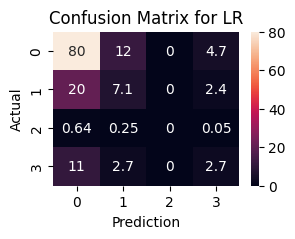

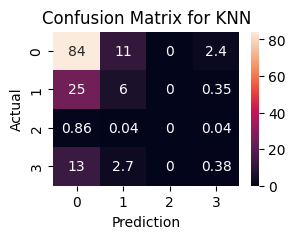

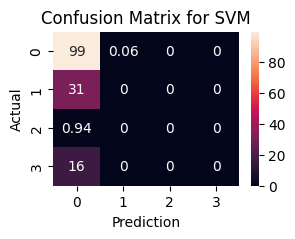

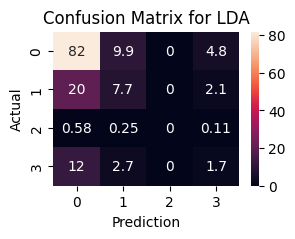

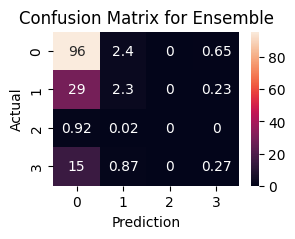

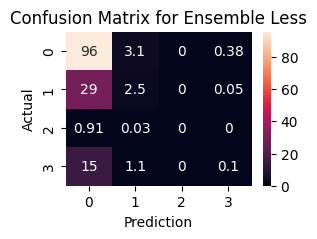

In [25]:
print_model_cfms(cfms)

Extract descriptive statistics from the accuracies.

In [26]:
stats = get_statistics(accs)
results = pd.DataFrame(stats, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_multiclass', 'KNN_multiclass', 
                                'SVM_multiclass', 'LDA_multiclass', 
                                'Ensemble_multiclass', 'Ensemble2_multiclass'])

results

,LR_multiclass,KNN_multiclass,SVM_multiclass,LDA_multiclass,Ensemble_multiclass,Ensemble2_multiclass
Mean,0.580764,0.578854,0.632293,0.587580,0.627771,0.626624
STD,0.035673,0.037512,0.034523,0.036013,0.038060,0.037991
Max,0.681529,0.694268,0.726115,0.687898,0.732484,0.732484
Min,0.484076,0.496815,0.535032,0.477707,0.535032,0.528662


Perform cross validation to compare this to the 100 iteration method.

In [27]:
perform_cross_validation(X, y)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the num

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model		CV Mean		CV std
{'LR': (0.5320276497695853, 0.08988402765156048), 'KNN': (0.569994879672299, 0.04565199298031557), 'SVM': (0.6290066564260113, 0.011408367044158626), 'LDA': (0.5255504352278545, 0.09554192598436623), 'Ensemble': (0.6178443420378904, 0.04003592873495129), 'Ensemble Less': (0.6321300563236047, 0.028342401413599498)}


## Normalized Dataframe

This model will use a normalized version of the dataframe. 
This method will adjust the features to be normally distributed.

This should reduce some of the bias that results from the different scales in the dataframe's features

### Separate data

Make a copy of the original dataframe to ensure that it is preserved. 
Split the data into features and target.

In [28]:
df_region_w_dx_norm = df_region_w_dx.copy()

X_norm = df_region_w_dx_norm.drop('DX', axis=1)
y_norm = df_region_w_dx_norm['DX']

### Normalize columns

Normalize the features and update the feature dataframe to use these changes.

In [29]:
X_norm = normalize_features(X_norm)

### Evaluate Accuracy

Determine the accuracy of using this dataframe. 

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [30]:
accs_norm, cfms_norm = get_accuracies(X_norm, y)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

#### View Confusion Matrices

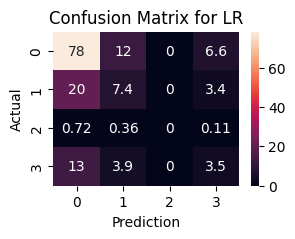

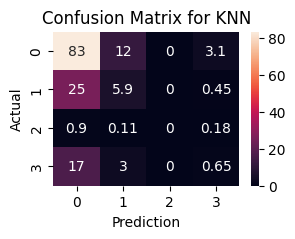

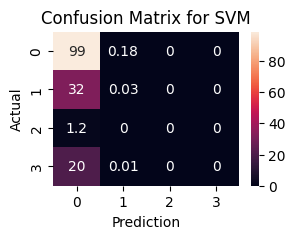

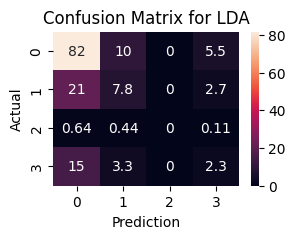

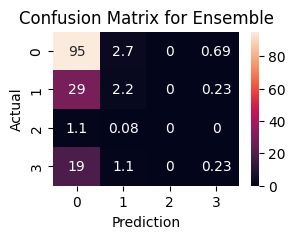

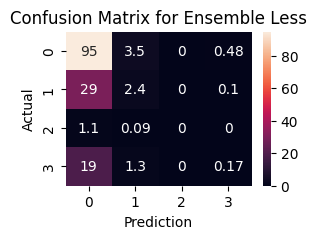

In [31]:
print_model_cfms(cfms_norm)

Extract descriptive statistics from the accuracies.

In [32]:
stats_norm = get_statistics(accs_norm)
results_norm = pd.DataFrame(stats_norm, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_multiclass_norm', 'KNN_multiclass_norm', 
                                'SVM_multiclass_norm', 'LDA_multiclass_norm',
                                'Ensemble_multiclass_norm', 'Ensemble2_multiclass_norm'])

results_norm

,LR_multiclass_norm,KNN_multiclass_norm,SVM_multiclass_norm,LDA_multiclass_norm,Ensemble_multiclass_norm,Ensemble2_multiclass_norm
Mean,0.572675,0.572293,0.628599,0.586815,0.622484,0.619427
STD,0.033993,0.029989,0.035334,0.035345,0.035883,0.035077
Max,0.656051,0.649682,0.694268,0.675159,0.687898,0.694268
Min,0.496815,0.503185,0.535032,0.484076,0.541401,0.535032


#### Cross-validation

Perform cross validation on this dataset with the models from before. This is done to compare the results to the train-test split method.

In [33]:
perform_cross_validation(X_norm, y_norm)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the num

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model		CV Mean		CV std
{'LR': (0.5240399385560676, 0.08574159971760378), 'KNN': (0.5588325652841781, 0.03988597244728857), 'SVM': (0.6258320532514081, 0.013539007225528591), 'LDA': (0.5255504352278545, 0.09554192598436623), 'Ensemble': (0.6178187403993857, 0.04273937255957056), 'Ensemble Less': (0.6257552483358935, 0.03313583982336045)}


--------------------------------------------------------------------------------------------------------------------------------

# Binary Classification

This section investigates how models perform when predicting whether a patient has ADHD or not. 

This is accomplished by converting the diagnosis to a binary value based on if their diagnosis is a control or has some type of ADHD. 
For this feature, 'True' signifies the subject has ADHD and 'False' signifies the subject is a control and does not have ADHD.

Theoretically, this model should perform better than the multi-class classification since it is simpler.

## Build the dataframe

Create a dataframe of the subjects, regions and their diagnosis.

Make the diagnosis a series with the phenotypic array as the index

In [34]:
# Add the binary classification for each diagnosis to a Series
diagnosis_binary = pd.Series([diag>0 for site_pheno in dx for diag in site_pheno], index=patient_ids)

### Combine

Add the diagnosis Series to the regions dataframe.

In [35]:
# Make a copy of the region dataframe
df_region_w_dx_binary = df_subject_x_region.copy()

# Drop the rows with missing files or folders from the Series
filtered_diagnosis_binary = diagnosis_binary.drop(index=subjects_dropped)

# Add the diagnosis to the region dataframe
df_region_w_dx_binary['DX'] = filtered_diagnosis_binary

View the number of subjects with and without ADHD.

In [36]:
df_region_w_dx_binary['DX'].value_counts()

DX
False    395
True     233
Name: count, dtype: int64

## Evaluate Accuracy

Build models and evaluate the accuracy

Separate dataframe into features and targets

In [37]:
X_binary = df_region_w_dx_binary.drop('DX', axis=1)
y_binary = df_region_w_dx_binary['DX']

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [38]:
accs_binary, cfm_binary = get_accuracies(X_binary, y_binary)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

#### View Confusion Matrices

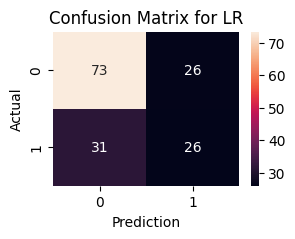

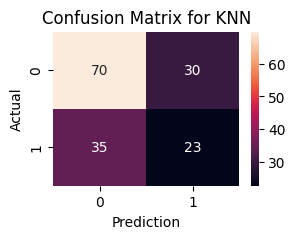

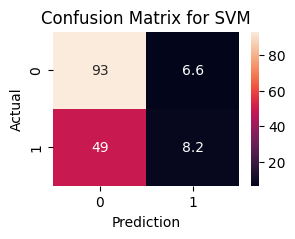

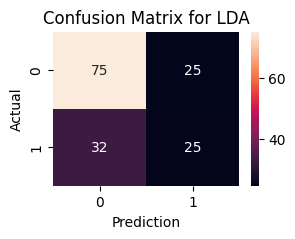

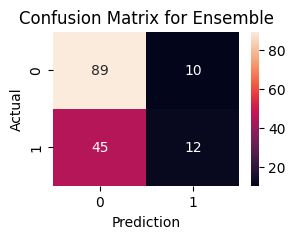

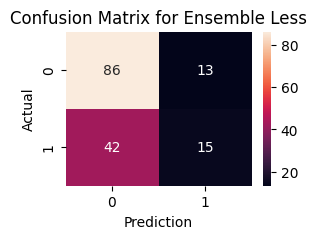

In [39]:
print_model_cfms(cfm_binary)

Extract descriptive statistics from the accuracies.

In [40]:
stats_binary = get_statistics(accs_binary)
results_binary = pd.DataFrame(stats_binary, 
                              index=['Mean', 'STD', 'Max', 'Min'], 
                              columns=['LR_binary', 'KNN_binary', 
                                       'SVM_binary', 'LDA_binary', 
                                       'Ensemble_binary', 'Ensemble2_binary'])

results_binary

,LR_binary,KNN_binary,SVM_binary,LDA_binary,Ensemble_binary,Ensemble2_binary
Mean,0.633312,0.589108,0.644904,0.637070,0.645287,0.644522
STD,0.038336,0.032233,0.034269,0.032590,0.034848,0.033313
Max,0.738854,0.675159,0.751592,0.707006,0.745223,0.757962
Min,0.554140,0.503185,0.566879,0.528662,0.566879,0.566879


#### Cross-validation

Perform cross validation on this dataset with the models from before. This is done to compare the results to the train-test split method.

In [41]:
perform_cross_validation(X_binary, y_binary)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model		CV Mean		CV std
{'LR': (0.5541986687147977, 0.06487477929407957), 'KNN': (0.5460061443932411, 0.07016811312410934), 'SVM': (0.6224782386072709, 0.04237828325572018), 'LDA': (0.5669226830517153, 0.05333641645229613), 'Ensemble': (0.6002560163850488, 0.06877461697023386), 'Ensemble Less': (0.6033538146441373, 0.07762288869866354)}


## Normalized Binary Dataframe

This model will use a normalized version of the dataframe. 
This method will adjust the features to be normally distributed.

This should reduce some of the bias that results from the different scales in the dataframe's features

### Separate data

Make a copy of the original dataframe to ensure that it is preserved. 
Split the data into features and target.

In [42]:
df_region_w_dx_binary_norm = df_region_w_dx_binary.copy()

X_binary_norm = df_region_w_dx_binary_norm.drop('DX', axis=1)
y_binary_norm = df_region_w_dx_binary_norm['DX']

### Normalize columns

Normalize the features and update the feature dataframe to use these changes.

In [43]:
X_binary_norm = normalize_features(X_binary_norm)

### Evaluate Accuracy

Determine the accuracy of using this dataframe. 

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [44]:
accs_binary_norm, cfm_binary_norm = get_accuracies(X_binary_norm, y_binary)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

#### View Confusion Matrices

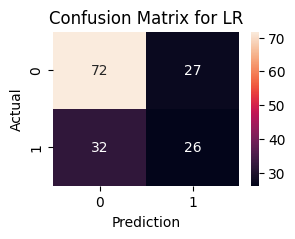

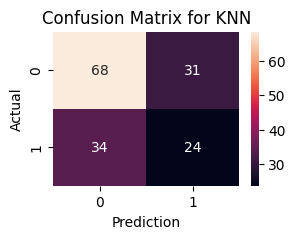

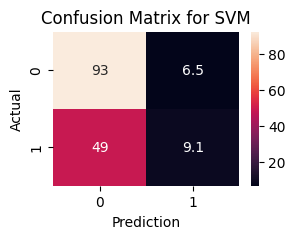

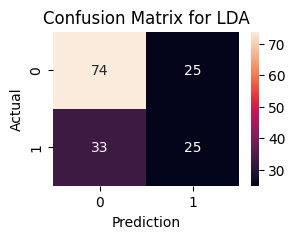

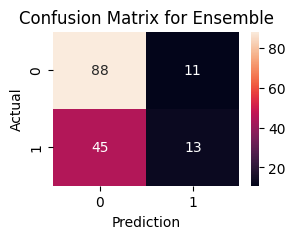

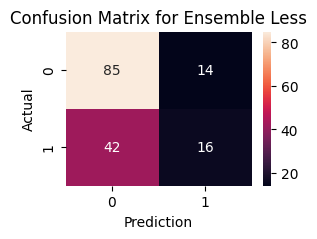

In [45]:
print_model_cfms(cfm_binary_norm)

Extract descriptive statistics from the accuracies.

In [46]:
stats_binary_norm = get_statistics(accs_binary_norm)
results_binary_norm = pd.DataFrame(stats_binary_norm, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_binary_norm', 'KNN_binary_norm', 
                                'SVM_binary_norm', 'LDA_binary_norm', 
                                'Ensemble_binary_norm', 'Ensemble2_binary_norm'])

results_binary_norm

,LR_binary_norm,KNN_binary_norm,SVM_binary_norm,LDA_binary_norm,Ensemble_binary_norm,Ensemble2_binary_norm
Mean,0.623185,0.587134,0.647643,0.629108,0.646115,0.643248
STD,0.034415,0.033648,0.034275,0.034322,0.028030,0.027829
Max,0.700637,0.675159,0.707006,0.719745,0.707006,0.700637
Min,0.547771,0.503185,0.554140,0.528662,0.560510,0.573248


#### Cross-validation

Perform cross validation on this dataset with the models from before. This is done to compare the results to the train-test split method.

In [47]:
perform_cross_validation(X_binary_norm, y_binary_norm)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model		CV Mean		CV std
{'LR': (0.5478750640040964, 0.057939963998058924), 'KNN': (0.5475934459805427, 0.07334629942947873), 'SVM': (0.614516129032258, 0.056598274780435276), 'LDA': (0.5669226830517153, 0.05333641645229613), 'Ensemble': (0.5954941116231438, 0.06932137083346669), 'Ensemble Less': (0.5970302099334358, 0.07661762451867675)}


--------------------------------------------------------------------------------------------------------------------------------

# Complete Results

Combine the accuracy from the multiclass and binary tests. 

Concatenate the two results to a single dataframe to export.

In [48]:
results_complete = pd.concat([results, results_norm, results_binary, results_binary_norm], axis=1)
results_complete

,LR_multiclass,KNN_multiclass,SVM_multiclass,LDA_multiclass,Ensemble_multiclass,Ensemble2_multiclass,LR_multiclass_norm,KNN_multiclass_norm,SVM_multiclass_norm,LDA_multiclass_norm,...,SVM_binary,LDA_binary,Ensemble_binary,Ensemble2_binary,LR_binary_norm,KNN_binary_norm,SVM_binary_norm,LDA_binary_norm,Ensemble_binary_norm,Ensemble2_binary_norm
Mean,0.580764,0.578854,0.632293,0.587580,0.627771,0.626624,0.572675,0.572293,0.628599,0.586815,...,0.644904,0.637070,0.645287,0.644522,0.623185,0.587134,0.647643,0.629108,0.646115,0.643248
STD,0.035673,0.037512,0.034523,0.036013,0.038060,0.037991,0.033993,0.029989,0.035334,0.035345,...,0.034269,0.032590,0.034848,0.033313,0.034415,0.033648,0.034275,0.034322,0.028030,0.027829
Max,0.681529,0.694268,0.726115,0.687898,0.732484,0.732484,0.656051,0.649682,0.694268,0.675159,...,0.751592,0.707006,0.745223,0.757962,0.700637,0.675159,0.707006,0.719745,0.707006,0.700637
Min,0.484076,0.496815,0.535032,0.477707,0.535032,0.528662,0.496815,0.503185,0.535032,0.484076,...,0.566879,0.528662,0.566879,0.566879,0.547771,0.503185,0.554140,0.528662,0.560510,0.573248


In [49]:
results_complete.to_csv(base_folder_filepath + '\\Results\\2023.7.17-Region_Correlation-Results.csv')